In [36]:
import ee, datetime as dt
import pandas as pd
import requests, time
import numpy as np

import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt

In [2]:
ee.Initialize(project='stat-288-final-project-458620')

In [3]:
# MODIS land aerosol optical depth, daily 1 km
aod = ee.ImageCollection("MODIS/061/MCD19A2_GRANULES")

# MODIS 16-day NDVI, 16-day 1 km
ndvi = ee.ImageCollection("MODIS/MCD43A4_006_NDVI")

# VIIRS night-time lights, daily 1 km
ntl = ee.ImageCollection("NASA/VIIRS/002/VNP46A2")

In [4]:
# Print the first image's metadata and bands for each collection
def print_first_image_info(collection, name):
    first_img = collection.first()
    info = first_img.getInfo()
    print(f"--- {name} ---")
    print("ID:", info['id'])
    print("Bands:", [band['id'] for band in info['bands']])
    print("Properties:", list(info['properties'].keys()))
    print()

In [5]:
print_first_image_info(aod, "AOD")
print_first_image_info(ndvi, "NDVI")
print_first_image_info(ntl, "Night Lights")

--- AOD ---
ID: MODIS/061/MCD19A2_GRANULES/MCD19A2_A2000055_h00v08_061_2022153215218_01
Bands: ['Optical_Depth_047', 'Optical_Depth_055', 'AOD_Uncertainty', 'Column_WV', 'AOD_QA', 'Injection_Height', 'cosSZA', 'cosVZA', 'RelAZ', 'Scattering_Angle', 'Glint_Angle', 'FineModeFraction', 'AngstromExp_470-780']
Properties: ['SATELLITE', 'system:time_end', 'DESCRREVISION', 'system:time_start', 'ALGORITHMPACKAGENAME', 'LOCALVERSIONID', 'PGEVERSION', 'system:footprint', 'PRODUCTIONDATETIME', 'system:asset_size', 'ALGORITHMPACKAGEVERSION', 'system:index']

--- NDVI ---
ID: MODIS/MCD43A4_006_NDVI/2000_02_24
Bands: ['NDVI']
Properties: ['system:time_start', 'system:time_end', 'system:index']

--- Night Lights ---
ID: NASA/VIIRS/002/VNP46A2/2012_01_19
Bands: ['DNB_BRDF_Corrected_NTL', 'DNB_Lunar_Irradiance', 'Gap_Filled_DNB_BRDF_Corrected_NTL', 'Latest_High_Quality_Retrieval', 'Mandatory_Quality_Flag', 'QF_Cloud_Mask', 'Snow_Flag']
Properties: ['google:max_source_file_timestamp', 'num_tiles', 'DNB_

In [6]:
# helper fn to make 7-date composite
def week_stack(start):
    start = ee.Date(start)
    end = start.advance(7, 'day')
    aod_img  = (aod.filterDate(start, end)
                    .select(['Optical_Depth_047', 'AOD_QA', 'Column_WV'])
                    .median())
    ndvi_img = ndvi.filterDate(start, end).select('NDVI').median()
    ntl_img  = ntl.filterDate(start, end).select('DNB_BRDF_Corrected_NTL').median()
    return (aod_img.addBands([ndvi_img, ntl_img])
               .set({'system:time_start': start.millis()}))

In [7]:
# 6 yr image collection
def build_weekly_ic(start, stop):
    weeks = ee.List.sequence(0, start.difference(stop, 'week').abs(), 1)
    return ee.ImageCollection(weeks.map(lambda w:
        week_stack(start.advance(w, 'week'))))

In [8]:
src_start = ee.Date('2018-01-01'); src_stop = ee.Date('2024-12-31')
ic_weeks = build_weekly_ic(src_start, src_stop)

In [9]:
# Load environment variables
load_dotenv()
OPENAQ_API_KEY = os.getenv("OPENAQ_API_KEY")
HEADERS = {"X-API-Key": OPENAQ_API_KEY}  

BBOX_DELHI  = [76.75, 28.35, 77.45, 28.95]
BBOX_LAGOS  = [ 3.00,  6.30,  3.60,  6.80]

DATE_FROM   = '2018-01-01'
DATE_TO     = '2024-12-31'

In [10]:
API = 'https://api.openaq.org/v3/locations' 

def get_pm25_bbox(bbox, date_from, date_to, sleep=0.5, max_pages=50):
    """Return a DataFrame of raw PM2.5 readings in the bounding box."""
    params_base = {
        'parameters_id': 2,                   # PM2.5
        'datetime_from'  : date_from,
        'datetime_to'    : date_to,
        'bbox'       : ','.join(map(str, bbox)),
        'limit'      : 100,                  # max per request
        'page'       : 1
    }
    rows = []
    for page in range(1, max_pages + 1):
        params = params_base | {'page': page}
        r = requests.get(API, params=params, headers=HEADERS).json()
        rows.extend(r['results'])
        if page * params_base['limit'] >= r['meta']['found']:
            break
        time.sleep(sleep)                    # be kind to the API
    return pd.json_normalize(rows)

df_delhi_raw  = get_pm25_bbox(BBOX_DELHI,  DATE_FROM, DATE_TO)
df_lagos_raw  = get_pm25_bbox(BBOX_LAGOS,  DATE_FROM, DATE_TO)


In [11]:
OAQ = 'https://api.openaq.org/v3'
LIMIT = 100    

def stations_in_bbox(bbox):
    params = {
        'parameters_id' : 2,          # PM2.5
        'bbox'         : ','.join(map(str, bbox)),
        'limit'        : 100,        # max page size
        'page'         : 1
    }
    rows = []
    while True:
        r = requests.get(f'{OAQ}/locations', params=params, headers=HEADERS).json()
        rows.extend(r['results'])
        if params['page'] * params['limit'] >= r['meta']['found']:
            break
        params['page'] += 1; time.sleep(0.4)     # polite paging
    return pd.json_normalize(rows)

locs_delhi = stations_in_bbox(BBOX_DELHI)
locs_lagos = stations_in_bbox(BBOX_LAGOS)

print(locs_delhi[['id','name','coordinates.latitude','coordinates.longitude']].head())
print(locs_lagos[['id','name','coordinates.latitude','coordinates.longitude']].head())


   id                                          name  coordinates.latitude  \
0  13  Delhi Technological University, Delhi - CPCB             28.744000   
1  15                                   IGI Airport             28.560000   
2  16                                   Civil Lines             28.678700   
3  17                       R K Puram, Delhi - DPCC             28.563262   
4  50                    Punjabi Bagh, Delhi - DPCC             28.674045   

   coordinates.longitude  
0              77.120000  
1              77.094000  
2              77.226200  
3              77.186937  
4              77.131023  
       id   name  coordinates.latitude  coordinates.longitude
0  404479  Lagos              6.440483               3.406815


In [13]:
def get_sensors_for_location(location_id):
    """Get sensors for a specific location ID"""
    r = requests.get(f'{OAQ}/locations/{location_id}/sensors', headers=HEADERS).json()
    if 'results' in r:
        return r['results']
    return []

# Get sensors for each location
delhi_sensors = []
for idx, row in locs_delhi.iterrows():
    loc_id = row['id']
    sensors = get_sensors_for_location(loc_id)
    # Add location id and coordinates to each sensor
    for sensor in sensors:
        sensor['location_id'] = loc_id
        sensor['latitude'] = row['coordinates.latitude']
        sensor['longitude'] = row['coordinates.longitude']
    delhi_sensors.extend(sensors)
    time.sleep(0.3)  # polite paging

# Convert to DataFrames
delhi_sensors_df = pd.json_normalize(delhi_sensors) if delhi_sensors else pd.DataFrame()
print("Delhi sensors count:", len(delhi_sensors_df))

Delhi sensors count: 371


In [15]:
lagos_sensors = []
for idx, row in locs_lagos.iterrows():
    loc_id = row['id']
    sensors = get_sensors_for_location(loc_id)
    # Add location id and coordinates to each sensor
    for sensor in sensors:
        sensor['location_id'] = loc_id
        sensor['latitude'] = row['coordinates.latitude']
        sensor['longitude'] = row['coordinates.longitude']
    lagos_sensors.extend(sensors)
    time.sleep(0.3)  # polite paging

lagos_sensors_df = pd.json_normalize(lagos_sensors) if lagos_sensors else pd.DataFrame()
print("Lagos sensors count:", len(lagos_sensors_df))

Lagos sensors count: 1


In [17]:
# Filter sensors for PM2.5 measurements
delhi_pm25_sensors_df = delhi_sensors_df[delhi_sensors_df['parameter.name'] == 'pm25']
delhi_pm25_sensors_df = delhi_pm25_sensors_df.reset_index(drop=True)

lagos_pm25_sensors_df = lagos_sensors_df[lagos_sensors_df['parameter.name'] == 'pm25']
delhi_pm25_sensors_df = delhi_pm25_sensors_df.reset_index(drop=True)

print("Delhi PM2.5 sensors count:", len(delhi_pm25_sensors_df))
print("Lagos PM2.5 sensors count:", len(lagos_pm25_sensors_df))

# Display the first few rows of the filtered dataframes
print("\nDelhi PM2.5 sensors:")
if not delhi_pm25_sensors_df.empty:
    print(delhi_pm25_sensors_df[['id', 'name', 'parameter.name', 'parameter.units', 'datetimeFirst.utc', 'datetimeLast.utc']])
else:
    print("No PM2.5 sensors found in Delhi")

delhi_pm25_sensors_df

print("\nLagos PM2.5 sensors:")
if not lagos_pm25_sensors_df.empty:
    print(lagos_pm25_sensors_df[['id', 'name', 'parameter.name', 'parameter.units']].head())
else:
    print("No PM2.5 sensors found in Lagos")


Delhi PM2.5 sensors count: 61
Lagos PM2.5 sensors count: 1

Delhi PM2.5 sensors:
          id        name parameter.name parameter.units     datetimeFirst.utc  \
0      13864  pm25 µg/m³           pm25           µg/m³  2016-11-02T19:00:00Z   
1         30  pm25 µg/m³           pm25           µg/m³                   NaN   
2         34  pm25 µg/m³           pm25           µg/m³                   NaN   
3         35  pm25 µg/m³           pm25           µg/m³  2016-02-05T14:55:00Z   
4   12234787  pm25 µg/m³           pm25           µg/m³  2025-02-18T20:15:00Z   
..       ...         ...            ...             ...                   ...   
56     15621  pm25 µg/m³           pm25           µg/m³  2018-04-27T06:45:00Z   
57     15602  pm25 µg/m³           pm25           µg/m³  2018-04-27T07:00:00Z   
58     15606  pm25 µg/m³           pm25           µg/m³  2018-04-27T09:00:00Z   
59     15627  pm25 µg/m³           pm25           µg/m³  2018-04-27T08:00:00Z   
60     15626  pm25 µg/m³    

In [30]:
def measurements_for_sensor(sid, start, stop, lat=None, lon=None, location_id=None):
    """Return *all* rows for one sensor between dates."""
    rows, page = [], 1
    while True:
        params = {
            'datetime_from': start,
            'datetime_to': stop,
            'limit': LIMIT,
            'page': page
        }
        url = f'{OAQ}/sensors/{sid}/measurements/daily'
        response = requests.get(url, params=params, headers=HEADERS)
        try:
            r = response.json()
        except Exception as e:
            print("Failed to decode JSON!")
            print("Status code:", response.status_code)
            print("Response text:", response.text)
            raise e

            # Defensive: check for 'results'
        if 'results' not in r or not isinstance(r['results'], list):
                print("Skipping page", page, "due to unexpected API response structure:", r)
                page += 1
                time.sleep(0.4)
                continue

        # If 'results' is an empty list, we've reached the end
        if not r['results']:
            break

        # Attach sid, lat, lon to each measurement
        for entry in r['results']:
            entry['sid'] = sid
            entry['location_id'] = location_id
            entry['latitude'] = lat
            entry['longitude'] = lon

        rows.extend(r['results'])
        page += 1
        time.sleep(0.4)
    return rows

def city_measurements(sensor_df, start, stop):
    all_rows = []
    for _, row in sensor_df.iterrows():
        sid = row['id']
        location_id = row['location_id']
        lat = row['latitude']
        lon = row['longitude']
        all_rows.extend(measurements_for_sensor(sid, DATE_FROM, DATE_TO, lat, lon, location_id))
        time.sleep(1)
    print(len(all_rows))
    return pd.json_normalize(all_rows)

df_delhi_raw = city_measurements(delhi_pm25_sensors_df, DATE_FROM, DATE_TO)
df_lagos_raw = city_measurements(lagos_pm25_sensors_df, DATE_FROM, DATE_TO)

12507
353


In [52]:
df_delhi_raw

,value,coordinates,sid,location_id,latitude,longitude,flagInfo.hasFlags,parameter.id,parameter.name,parameter.units,...,coverage.observedCount,coverage.observedInterval,coverage.percentComplete,coverage.percentCoverage,coverage.datetimeFrom.utc,coverage.datetimeFrom.local,coverage.datetimeTo.utc,coverage.datetimeTo.local,datetime,week
52,259.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,11,02:45:00,11.0,11.0,2018-01-01T06:30:00Z,2018-01-01T12:00:00+05:30,2018-01-01T14:30:00Z,2018-01-01T20:00:00+05:30,2018-01-01 12:00:00+05:30,2018-01-01/2018-01-07
53,257.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,7,01:45:00,7.0,7.0,2018-01-02T07:15:00Z,2018-01-02T12:45:00+05:30,2018-01-02T12:15:00Z,2018-01-02T17:45:00+05:30,2018-01-02 12:45:00+05:30,2018-01-01/2018-01-07
54,253.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,15,03:45:00,16.0,16.0,2018-01-03T04:30:00Z,2018-01-03T10:00:00+05:30,2018-01-03T18:30:00Z,2018-01-04T00:00:00+05:30,2018-01-03 10:00:00+05:30,2018-01-01/2018-01-07
55,192.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,28,07:00:00,29.0,29.0,2018-01-03T19:00:00Z,2018-01-04T00:30:00+05:30,2018-01-04T18:15:00Z,2018-01-04T23:45:00+05:30,2018-01-04 00:30:00+05:30,2018-01-01/2018-01-07
56,236.0,None,35,17,28.563262,77.186937,False,2,pm25,µg/m³,...,31,07:45:00,32.0,32.0,2018-01-04T18:30:00Z,2018-01-05T00:00:00+05:30,2018-01-05T18:15:00Z,2018-01-05T23:45:00+05:30,2018-01-05 00:00:00+05:30,2018-01-01/2018-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12338,73.7,None,15629,5742,28.631049,77.284622,False,2,pm25,µg/m³,...,10,02:30:00,42.0,10.0,2018-05-08T19:30:00Z,2018-05-09T01:00:00+05:30,2018-05-09T14:00:00Z,2018-05-09T19:30:00+05:30,2018-05-09 01:00:00+05:30,2018-05-07/2018-05-13
12339,69.5,None,15629,5742,28.631049,77.284622,False,2,pm25,µg/m³,...,6,01:30:00,25.0,6.0,2018-05-10T05:00:00Z,2018-05-10T10:30:00+05:30,2018-05-10T11:30:00Z,2018-05-10T17:00:00+05:30,2018-05-10 10:30:00+05:30,2018-05-07/2018-05-13
12340,117.0,None,15629,5742,28.631049,77.284622,False,2,pm25,µg/m³,...,6,01:30:00,25.0,6.0,2018-05-11T01:45:00Z,2018-05-11T07:15:00+05:30,2018-05-11T08:30:00Z,2018-05-11T14:00:00+05:30,2018-05-11 07:15:00+05:30,2018-05-07/2018-05-13
12341,142.0,None,15629,5742,28.631049,77.284622,False,2,pm25,µg/m³,...,3,00:45:00,13.0,3.0,2018-05-12T03:30:00Z,2018-05-12T09:00:00+05:30,2018-05-12T05:30:00Z,2018-05-12T11:00:00+05:30,2018-05-12 09:00:00+05:30,2018-05-07/2018-05-13


In [40]:
original_df_delhi = df_delhi_raw
original_df_lagos = df_lagos_raw

### Data Cleaning!

In [46]:
# Make sure the units are all µg/m³
assert df_delhi_raw['parameter.units'].nunique() == 1 and df_delhi_raw['parameter.units'].iloc[0] == 'µg/m³'
assert df_lagos_raw['parameter.units'].nunique() == 1 and df_lagos_raw['parameter.units'].iloc[0] == 'µg/m³'

# # remove infeasible values
df_delhi_raw = df_delhi_raw[(df_delhi_raw.value >= 0) & (df_delhi_raw.value < 1000)]
df_lagos_raw = df_lagos_raw[(df_lagos_raw.value >= 0) & (df_lagos_raw.value < 1000)]

def iqr_filter(g):
    q1, q3 = g.value.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 3*iqr, q3 + 3*iqr        # Tukey fence
    return g[(g.value >= lo) & (g.value <= hi)]

df_delhi_raw = (df_delhi_raw.sort_values(['sid','datetime'])
        .groupby('sid', group_keys=False)
        .apply(iqr_filter))
df_lagos_raw = (df_lagos_raw.sort_values(['sid','datetime'])
        .groupby('sid', group_keys=False)
        .apply(iqr_filter))

/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_69019/2122928094.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(iqr_filter))
/var/folders/xp/ycg8s5194736y0vn0h3_t5dm0000gn/T/ipykernel_69019/2122928094.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(iqr_filter))


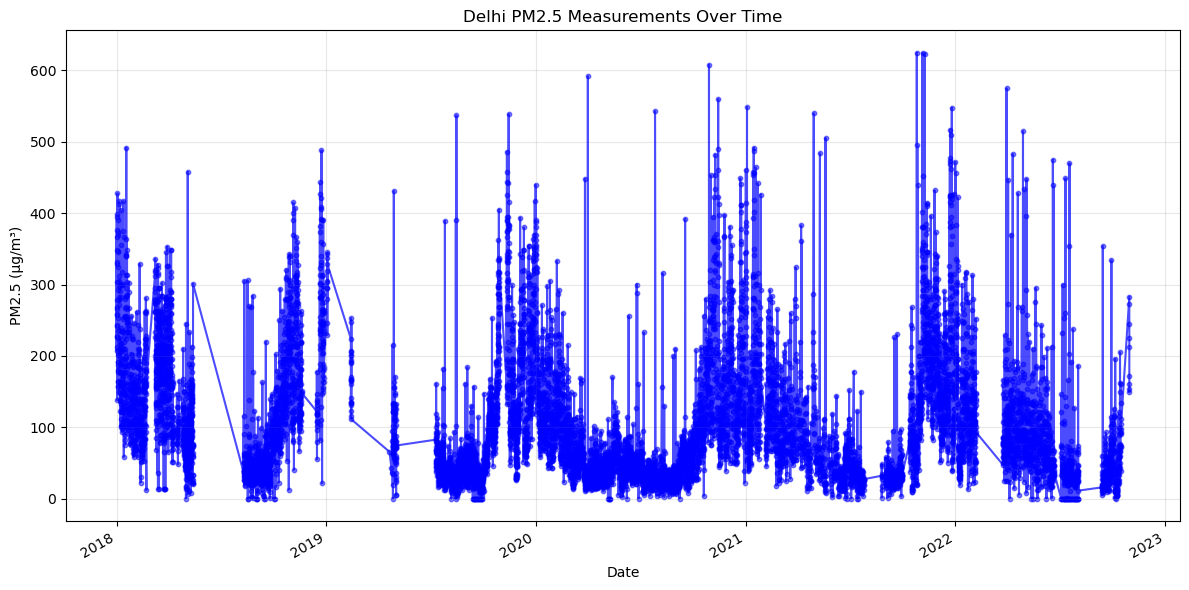

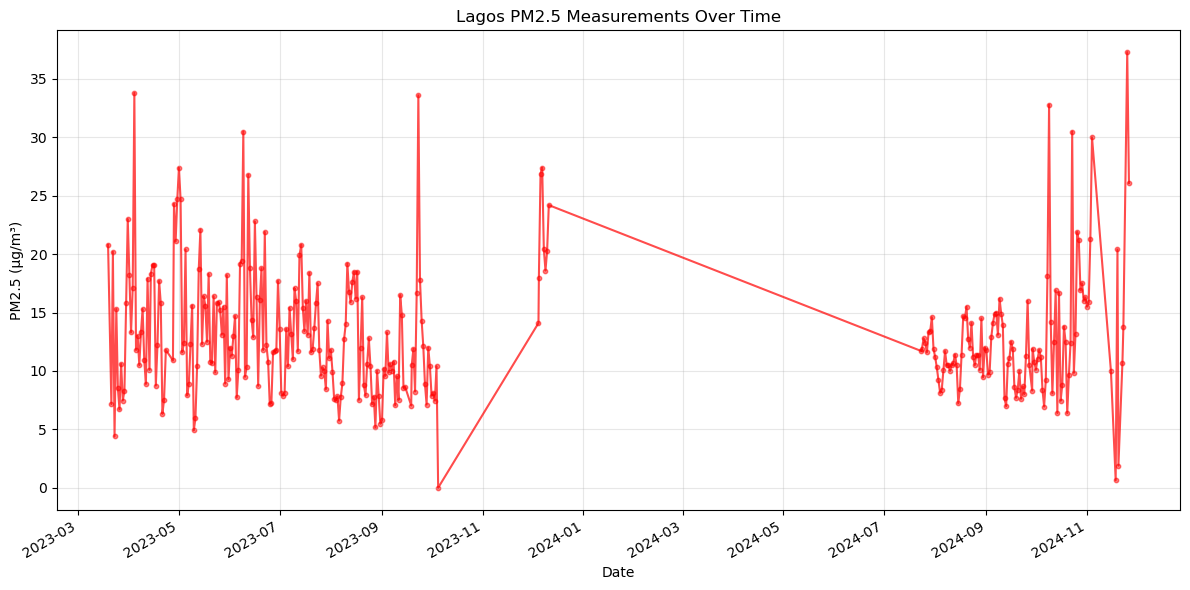

Delhi Statistics:
Number of measurements: 12388
Date range: 2017-12-31 23:15:00+05:30 to 2022-10-31 07:15:00+05:30
Average PM2.5: 105.59 µg/m³
Maximum PM2.5: 625.00 µg/m³

Lagos Statistics:
Number of measurements: 316
Date range: 2023-03-19 02:00:00+01:00 to 2024-11-26 09:00:00+01:00
Average PM2.5: 13.11 µg/m³
Maximum PM2.5: 37.30 µg/m³


In [48]:
# Convert the datetime strings to datetime objects for plotting
df_delhi_raw['datetime'] = pd.to_datetime(df_delhi_raw['coverage.datetimeFrom.local'])
df_delhi_raw_sorted = df_delhi_raw.sort_values('datetime')

df_lagos_raw['datetime'] = pd.to_datetime(df_lagos_raw['coverage.datetimeFrom.local'])
df_lagos_raw_sorted = df_lagos_raw.sort_values('datetime')

# Create a time series plot for Delhi
plt.figure(figsize=(12, 6))
plt.plot(df_delhi_raw_sorted['datetime'], df_delhi_raw_sorted['value'], 'b-', alpha=0.7)
plt.scatter(df_delhi_raw_sorted['datetime'], df_delhi_raw_sorted['value'], s=10, alpha=0.5, color='blue')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Delhi PM2.5 Measurements Over Time')
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a separate time series plot for Lagos
plt.figure(figsize=(12, 6))
plt.plot(df_lagos_raw_sorted['datetime'], df_lagos_raw_sorted['value'], 'r-', alpha=0.7)
plt.scatter(df_lagos_raw_sorted['datetime'], df_lagos_raw_sorted['value'], s=10, alpha=0.5, color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Lagos PM2.5 Measurements Over Time')
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics for both cities
print("Delhi Statistics:")
print(f"Number of measurements: {len(df_delhi_raw)}")
print(f"Date range: {df_delhi_raw_sorted['datetime'].min()} to {df_delhi_raw_sorted['datetime'].max()}")
print(f"Average PM2.5: {df_delhi_raw['value'].mean():.2f} µg/m³")
print(f"Maximum PM2.5: {df_delhi_raw['value'].max():.2f} µg/m³")

print("\nLagos Statistics:")
print(f"Number of measurements: {len(df_lagos_raw)}")
print(f"Date range: {df_lagos_raw_sorted['datetime'].min()} to {df_lagos_raw_sorted['datetime'].max()}")
print(f"Average PM2.5: {df_lagos_raw['value'].mean():.2f} µg/m³")
print(f"Maximum PM2.5: {df_lagos_raw['value'].max():.2f} µg/m³")